## ACES-3: Bagpipes SED Fitting

---

Bagpipes is one of the most regularlly used SED fitting codes for studying galaxies in the high-redshift Universe. Spectra can be generated using the BC03 or BPASS stellar models, with star formation histories of varying complexity and a variety of dust attenuation implementations. It uses an efficient Bayesian approach to fit both photometry and spectra.


The source GN-z11 was first identified in HST imaging as a candidate $z \sim10$ galaxy. It is exceptionally bright, with $\textrm{M}_{UV} = −21.6 \textrm{ AB mag} $ and as such was intitially therorised to be either transient or spurious. Follow up observations confirmed its status as a galaxy and JWST/NIRSpec measured a robust redshift at $z = 10.60$. Other JWST galaxies identified at these redshifts have $−19.3 < \textrm{M}_{UV}  < −18.4 \textrm{ AB mag}$ so GN-z11 is clearly unique within our current sample. 

Lets use Bagpipes to measure its physical properites! If you need further information on Bagpipes, take a look at the [documentation](https://bagpipes.readthedocs.io/en/latest/).

---

In [1]:
# Importing configured Bagpipes and additional modules.
import numpy as np
from astropy.table import Table
from astropy.cosmology import Planck18 as cosmo

import bagpipes as pipes
# Change this to 'nautilus' if required.
sampler = 'multinest'    

Bagpipes: Latex distribution not found, plots may look strange.


Bagpipes SED fits are performed on `galaxy` objects. We are only using photometry so need to initalise it with 

- ID: an object ID,

- load_data: a function taking ID as input and returning the corresponding photometry,
- filt_list: a list of paths filter response curves. Must be in the same order as photometry data.

As we are only dealing with a single object, we will use a dummy `load_data` function which extracts the photometry for a desired set of filters. Bagpipes expects all photometry to have units $\mu \textrm{Jy}$.

The photometry is stored as an astropy table in __gnz11_photometry.fits__. Let's load it and initalise a Bagpipes `galaxy` using just the JWST photometry.

In [2]:
# Load the photometry table and sort by wavelength.
gnz11 = Table.read('../gnz11_photometry.fits')
gnz11.sort('pivot')

In [3]:
# Selecting only the JWST filters.
filters = [f'JWST/NIRCam.{f}' for f in ['F115W', 'F150W', 'F200W', 'F277W', 'F335M', 'F356W',
                                        'F410M', 'F444W']]

# Define the dummy function for passing fluxes and errors to Bagpipes.
def load_data(ID, gnz11 = gnz11, filters = filters):

    mask = [f in filters for f in gnz11['filter']]

    # Convert from nJy to uJy.
    photometry = np.c_[gnz11[mask]['flux']/1e3, gnz11[mask]['error']/1e3]

    return photometry

In [4]:
# Paths to filter transmission files.
jwst_filters = ["filters/JWST_NIRCam.F115W.dat", "filters/JWST_NIRCam.F150W.dat",
                     "filters/JWST_NIRCam.F200W.dat", "filters/JWST_NIRCam.F277W.dat",
                     "filters/JWST_NIRCam.F335M.dat", "filters/JWST_NIRCam.F356W.dat",
                     "filters/JWST_NIRCam.F410M.dat", "filters/JWST_NIRCam.F444W.dat"]

In [5]:
# Create the bagpipes galaxy.
bp_galaxy = pipes.galaxy("1", load_data, filt_list=jwst_filters, spectrum_exists=False)

The Bagpipes fitting instructions are stored within a single nested dictionary. Each component is a sub-dictionary containing allowed ranges and priors for each model element. With this defined, we can then run the fitting procedue with `bagpipes.fit` which will create a file called "ID.h5" in <u>pipes/posterior</u>. If you have already fit a galaxy with one set of parameters and now wish to change them, you will need to delete this file or `bagpipes.fit` will return the stored data. 

If you select parameter ranges beyond the internal limits, this function will begin to throw errors until your IDE crashes. It's worth paying attention and interupting the kernel before this happens. You don't need to worry about "MultiNest Warning!" though.

In [6]:
fit_info = {}   

fit_info["redshift"] = (0,20)    # Observed redshift.

# Dust.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,5)    # Absolute V-band attenuation. [mag]
fit_info["dust"] = dust

# Assume an constant SFH.
constant = {}
constant["massformed"] = (5,15)    # Log of total stellar mass formed. [Msol]
constant["metallicity"] = (1e-4,2)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.

constant["age_max"] = (0, float(cosmo.age(0).value))    # Time since SF switched on. [Gyr]
constant["age_min"] = (0, float(cosmo.age(0).value))    # Time since SF switched off. [Gyr]

fit_info['constant'] = constant

# Nubular.
nebular = {}
nebular["logU"] = (-4,-2)    # Log of the ionization parameter. 
fit_info["nebular"] = nebular

In [7]:
# Fit the photometry.
fit = pipes.fit(bp_galaxy, fit_info, run = 'gnz11_jwst_bands')
fit.fit(verbose=False, sampler=sampler)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            7  of mode            1  is converging towards the edge of the pr

/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass


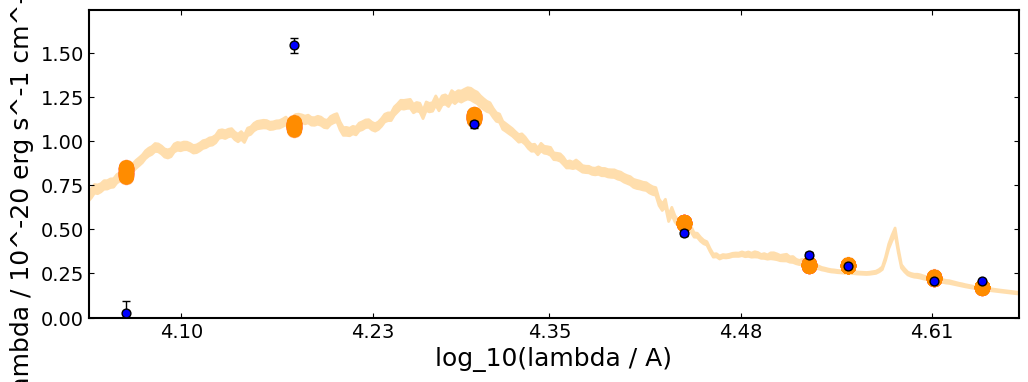

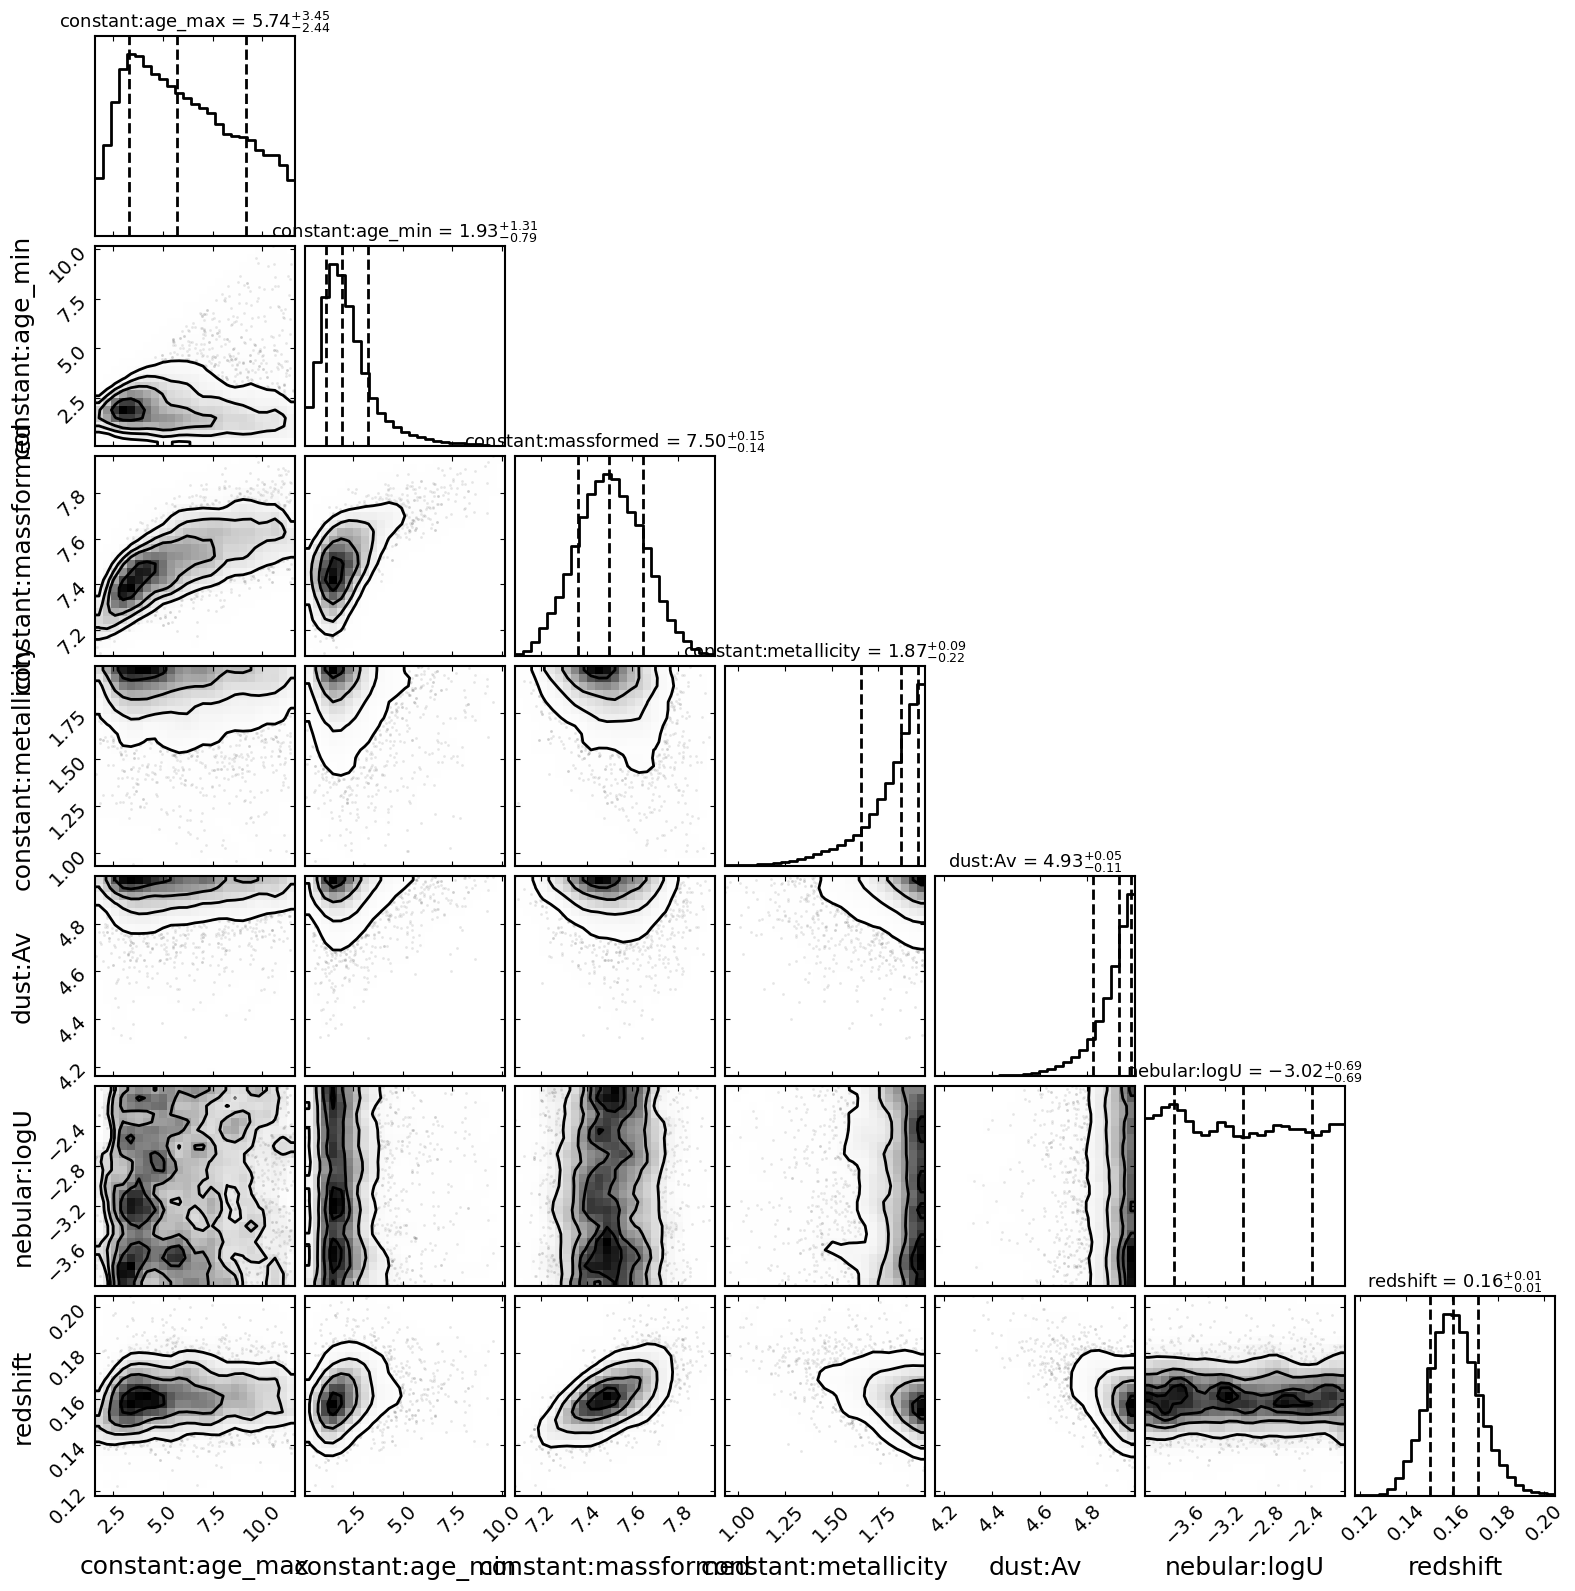

In [8]:
# Plot the fitted spectrum and recovered parameters.
fit.plot_spectrum_posterior(save=False, show=True)
fit.plot_corner()

You should find that Bagpipes fits GN-z11 as a low-redshift quiesent galaxy. The name of the galaxy alone should suggest to you that this is not right, however we would not have that luxury without the spectroscopic redshift. In practice, the poor fit of the spectrum would also be an indicator, but this highlights the risks of SED fitting, especially on large samples where it's unfeasable to inspect every fit.

__Task:__ Get the right solution!

Can you get Bagpipes to return the spectroscopic $z = 10.60$ solution? You can try improving the filter coverage or using different model components. Describe why you think each change might improve the fit.

Do you believe the infered physical properites to be accurate? Why? Is there a way to improve their reliablility?

__Extension:__ Find some photometry of an important galaxy in your field (if there is one) and repeat the process. You can get new filter transmission curves from the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/index.php?asttype=astro) is needed.